**Objective:**  The goal of this assignment is to develop your skills in finding, selecting, understanding, and preparing a dataset for a machine learning problem. You'll need to demonstrate an understanding of data quality issues and apply appropriate techniques to prepare the data.

**Libraries & functions used:**

In [1]:
import pandas as pd # creating/visualizing data frames
import seaborn as sns # visualizations, such as the correlation heat map
import matplotlib.pyplot as plt # visualizations
from pandas.plotting import scatter_matrix # visualization
import sklearn
from sklearn.preprocessing import StandardScaler # standardization of all numerical values
import hashlib


# from sklearn.preprocessing import OneHotEncoder --> Gave this method a try but used the pandas method instead
# import numpy as np --> Thought I might need this library, but I didn't end up Log scaling any of my columns

In [2]:
# I couldn't tell at times if a dataframe had changed. I created this function to hash the dataframes for comparison
# Source: https://chat.openai.com/share/26491ada-cc72-4e7f-9567-98059f2d0c82

def change_checker(df):

  df_string = df.to_string()
  hash_object = hashlib.sha256(df_string.encode())
  hash_hex = hash_object.hexdigest()

  return hash_hex

In [3]:
# This function allows you to see each row with an outlier, with respect to a specific column

def outlier_list_maker(column:str):

  outlier_list = []

  percentile_25 = my_raw_data[column].quantile(0.25)
  percentile_75 = my_raw_data[column].quantile(0.75)
  median = my_raw_data[column].median()
  iqr = percentile_75 - percentile_25
  iqr_1_5 = iqr*1.5

  for i in range(len(my_raw_data)):
    if (my_raw_data.loc[i, column] < (percentile_25 - iqr_1_5)) or (my_raw_data.loc[i,column]> (percentile_75 + iqr_1_5)):
      outlier_list.append(my_raw_data.iloc[i,:])

  return outlier_list


#Task 1: Find a datset#


---



My data set is information about the 5000 most common Spanish words, derived from [this dictionary](https://www.routledge.com/A-Frequency-Dictionary-of-Spanish-Core-Vocabulary-for-Learners/Davies-Hayward-Davies/p/book/9781138686540).

Note: I have a pdf version of dictionary found in the link above. In another notebook, I sorted the raw text into the dataframe you see here. If you want to see that notebook please let me know!


**What kind of machine learning problem could this dataset be used to address?**

>>*   Binary classification: given a new Spanish word, tell the user whether it is "common" or "not common."

>>*   Regression: given a new Spanish word, predict the words frequency rating. For example, "paradero" is the 7500 most common word in the Spanish language.

**What are the potential insights that could be gained from this data?**

>>* If a language learner knows the frequency with which a new word occurs, they can focus their study on high frequency words. For example, I automate making flash cards for Spanish words. If I could use machine learning to add into the flash card how frequent each word is, then I can spend either more, or less, time learning that word. If I am struggling to remember a word in the top 5000, I will likely keep struggling until the word sticks in my brain. However, if the word is 49,999 on the frequency scale, I will likely move on to a new word.




In [4]:
my_raw_data = pd.read_csv('Spanish_data_v4.csv')

In [5]:
my_raw_data.head()

,Raw word,Part of Speech,frequency score,Word length,Contains special characters?,# of vowels,# of consonants,Contains repeated sequential characters?,Ends with a vowel?,e count,a count,o count,s count
0,abajo,adv,631,5,False,3,2,False,True,0,2,1,0
1,abandonado,adj,2298,10,False,5,5,False,True,0,3,2,0
2,abandonar,v,638,9,False,4,5,False,False,0,3,1,0
3,abandono,noun,2524,8,False,4,4,False,True,0,2,2,0
4,abanico,noun,4422,7,False,4,3,False,True,0,2,1,0


#Task 2:	Exploratory Data Analysis (EDA):#

---
**Data types and distributions:**
*   Each feature is either an int64 or bool with the exceptions of 'Raw word' and 'Part of Speech'. I will transform 'Part of Speech' with OneHotEncoding.

**Missing values:**
*   I deleted rows with missing values when I scraped the dictionary to make the original data set. During this process the data set lost roughly 40 words, which is negligible in a dataset of around 5000.

**Outliers:**
* The box plots for each column show outliers ranging from 4 for consonant/vowel counts to 198 for e counts. I wrote a function to see what the full row looks like for each outlier with respect to a specific column (see outlier_list_maker). The words did not seem abnormal enough to warrant removing them. As a result, I will use standardization for feature scaling to reduce the effect of outliers.

**Relationships between features:**
* Unsurprisingly, word length, # of consonants, and # of vowels display colinearity. Thus, I dropped word length because it is redundant.
* I created two new variables that divide the # of consonants and # of vowels by the length of the word. While these new variables are less correlated with a words frequency then total consonant/vowel count, they show a higher correlation with part of speech. Predicting part of speech could also be a useful machine learning problem.







In [6]:
my_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4886 entries, 0 to 4885
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Raw word                                  4886 non-null   object
 1   Part of Speech                            4886 non-null   object
 2   frequency score                           4886 non-null   int64 
 3   Word length                               4886 non-null   int64 
 4   Contains special characters?              4886 non-null   bool  
 5   # of vowels                               4886 non-null   int64 
 6   # of consonants                           4886 non-null   int64 
 7   Contains repeated sequential characters?  4886 non-null   bool  
 8   Ends with a vowel?                        4886 non-null   bool  
 9   e count                                   4886 non-null   int64 
 10  a count                                   4886 n

In [7]:
my_raw_data.describe()

,frequency score,Word length,# of vowels,# of consonants,e count,a count,o count,s count
count,4886.000000,4886.000000,4886.000000,4886.000000,4886.000000,4886.000000,4886.000000,4886.000000
mean,2534.760745,7.478715,3.202824,4.100287,0.787761,0.890708,0.638764,0.323987
std,1429.672005,2.299094,1.106046,1.420342,0.864980,0.787003,0.686083,0.522205
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1298.250000,6.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2537.500000,7.000000,3.000000,4.000000,1.000000,1.000000,1.000000,0.000000
75%,3773.750000,9.000000,4.000000,5.000000,1.000000,1.000000,1.000000,1.000000
max,5000.000000,19.000000,9.000000,10.000000,6.000000,4.000000,4.000000,3.000000


In [8]:
my_raw_data.corr()

<ipython-input-8-bacbae354821>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  my_raw_data.corr()


,frequency score,Word length,Contains special characters?,# of vowels,# of consonants,Contains repeated sequential characters?,Ends with a vowel?,e count,a count,o count,s count
frequency score,1.000000,0.220583,0.059336,0.201272,0.184245,0.039789,0.071636,0.047836,0.095591,0.035367,0.041233
Word length,0.220583,1.000000,0.113033,0.850872,0.925932,0.049746,-0.057487,0.421572,0.147828,0.088630,0.198331
Contains special characters?,0.059336,0.113033,1.000000,-0.133132,0.017969,0.007239,-0.097831,-0.133184,-0.129887,-0.039674,0.017871
# of vowels,0.201272,0.850872,-0.133132,1.000000,0.634808,-0.014222,0.145869,0.424162,0.223486,0.160506,0.120124
# of consonants,0.184245,0.925932,0.017969,0.634808,1.000000,0.089799,-0.180384,0.388233,0.100092,0.029201,0.222796
Contains repeated sequential characters?,0.039789,0.049746,0.007239,-0.014222,0.089799,1.000000,-0.017506,0.004004,0.020449,-0.017179,-0.062889
Ends with a vowel?,0.071636,-0.057487,-0.097831,0.145869,-0.180384,-0.017506,1.000000,0.099037,-0.094601,0.311840,0.004762
e count,0.047836,0.421572,-0.133184,0.424162,0.388233,0.004004,0.099037,1.000000,-0.198873,-0.192688,0.073860
a count,0.095591,0.147828,-0.129887,0.223486,0.100092,0.020449,-0.094601,-0.198873,1.000000,-0.319565,-0.087163
o count,0.035367,0.088630,-0.039674,0.160506,0.029201,-0.017179,0.311840,-0.192688,-0.319565,1.000000,0.050759


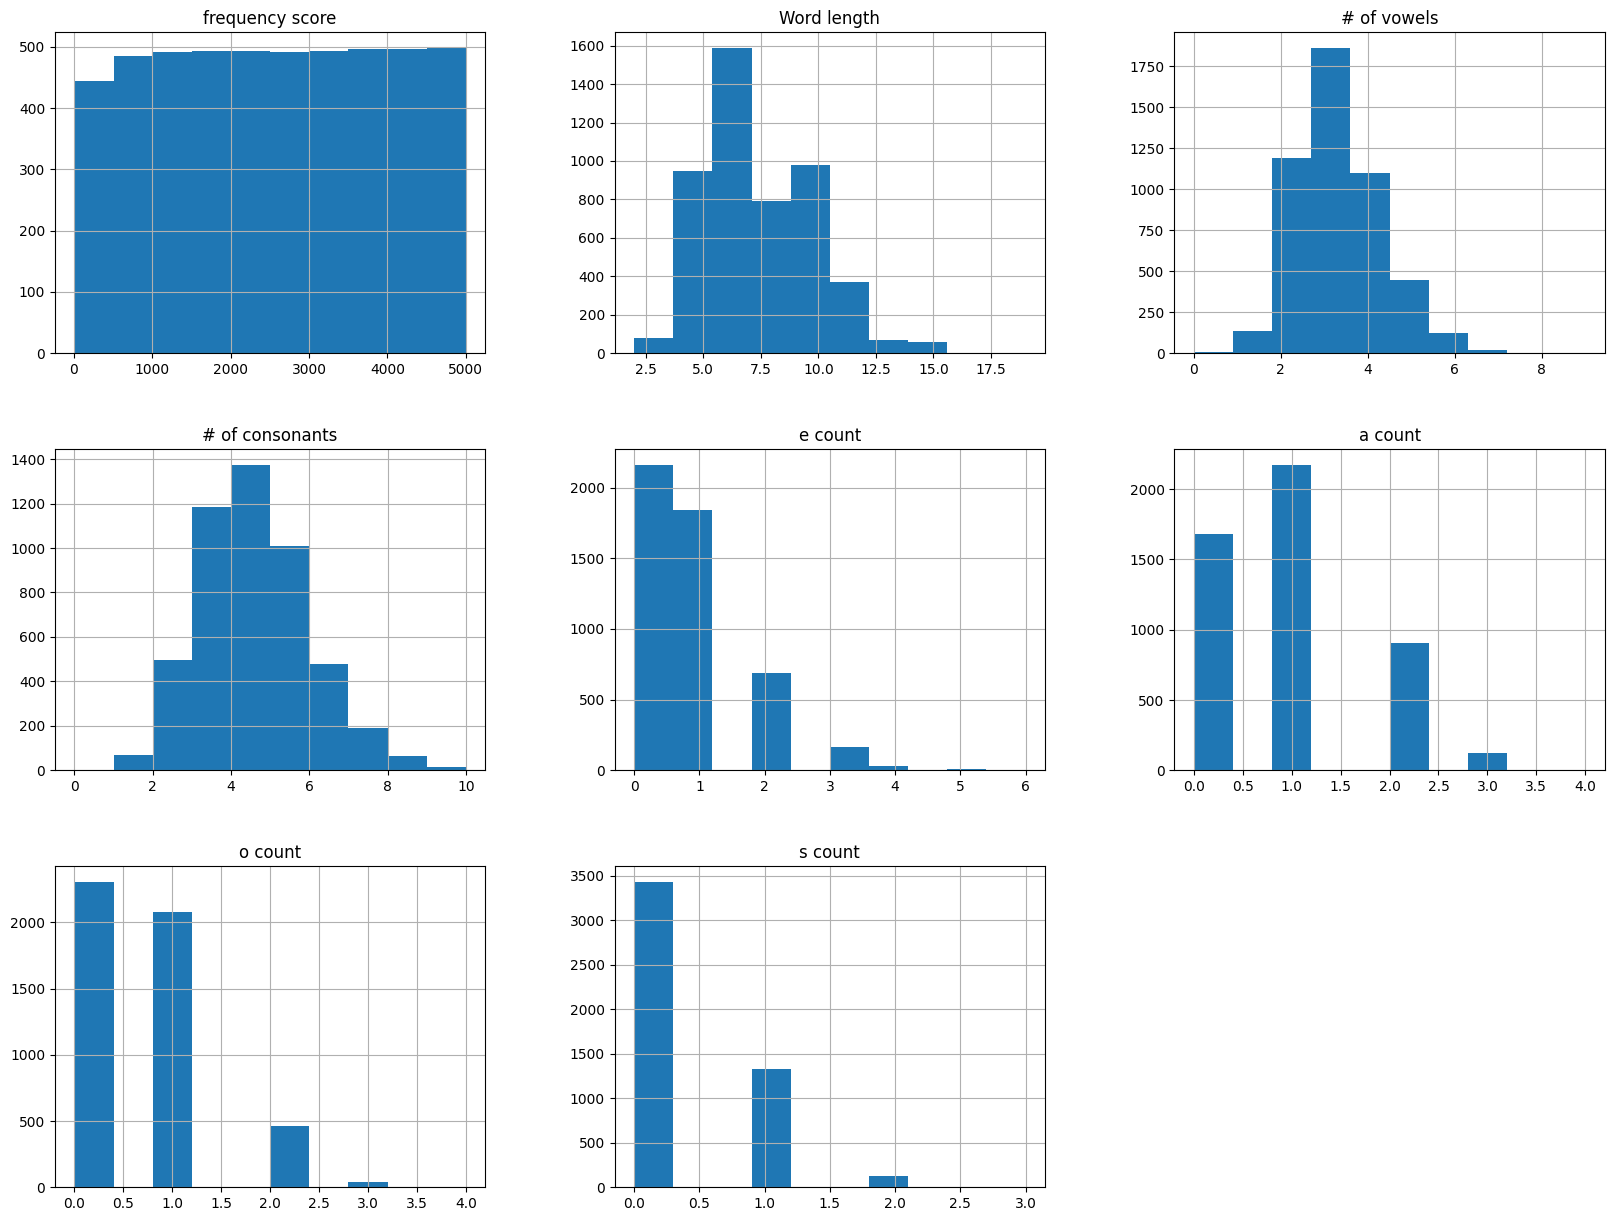

In [9]:
my_raw_data.hist(figsize = (20,15))
plt.show()

<ipython-input-10-08c80ad3f209>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(my_raw_data.corr(), cmap="BrBG", annot = True)


<Axes: >

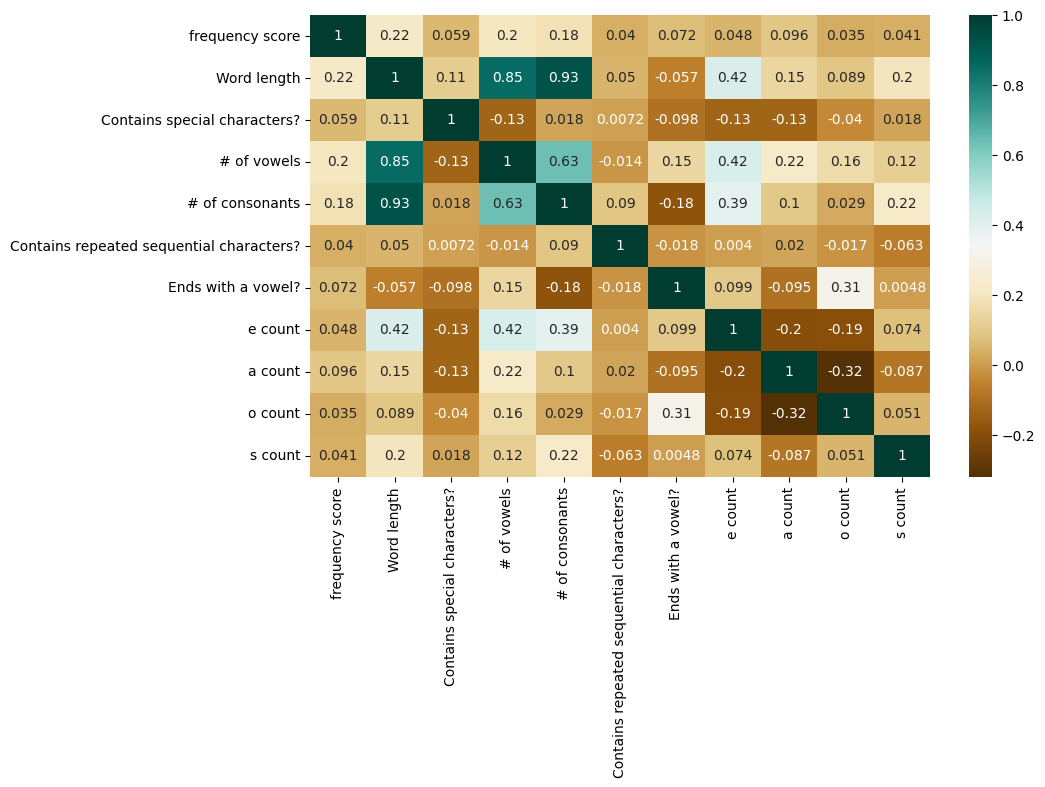

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(my_raw_data.corr(), cmap="BrBG", annot = True)

<Axes: xlabel='Word length'>

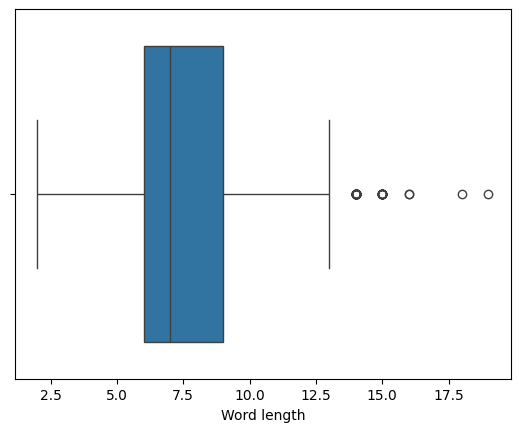

In [11]:
sns.boxplot(x = my_raw_data['Word length'])

In [12]:
outliers_word_length = outlier_list_maker('Word length')
len(outliers_word_length)

61

In [13]:
my_raw_data['Contains special characters?'].value_counts()

False    4032
True      854
Name: Contains special characters?, dtype: int64

<Axes: xlabel='# of vowels'>

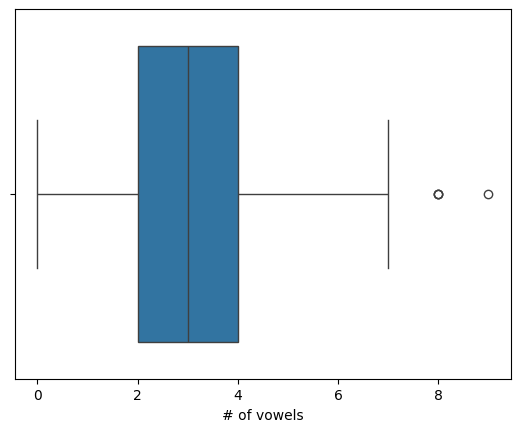

In [14]:
sns.boxplot(x = my_raw_data['# of vowels'])

In [15]:
vowels_outliers = outlier_list_maker('# of vowels')
print(len(vowels_outliers))
vowels_outliers

4


[Raw word                                    extraordinariamente
 Part of Speech                                              adv
 frequency score                                            3953
 Word length                                                  19
 Contains special characters?                              False
 # of vowels                                                   9
 # of consonants                                              10
 Contains repeated sequential characters?                  False
 Ends with a vowel?                                         True
 e count                                                       3
 a count                                                       3
 o count                                                       1
 s count                                                       0
 Name: 2036, dtype: object,
 Raw word                                    independientemente
 Part of Speech                                             adv

<Axes: xlabel='# of consonants'>

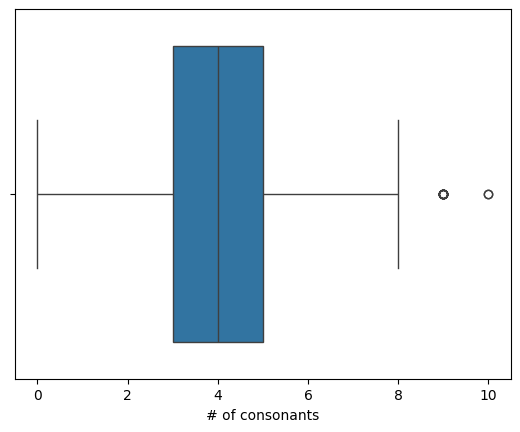

In [16]:
sns.boxplot(x = my_raw_data['# of consonants'])

In [17]:
consonants_outliers = outlier_list_maker('# of consonants')
print(len(vowels_outliers))
vowels_outliers

4


[Raw word                                    extraordinariamente
 Part of Speech                                              adv
 frequency score                                            3953
 Word length                                                  19
 Contains special characters?                              False
 # of vowels                                                   9
 # of consonants                                              10
 Contains repeated sequential characters?                  False
 Ends with a vowel?                                         True
 e count                                                       3
 a count                                                       3
 o count                                                       1
 s count                                                       0
 Name: 2036, dtype: object,
 Raw word                                    independientemente
 Part of Speech                                             adv

In [18]:
my_raw_data['Contains repeated sequential characters?'].value_counts()

False    4623
True      263
Name: Contains repeated sequential characters?, dtype: int64

In [19]:
my_raw_data['Ends with a vowel?'].value_counts()

True     2852
False    2034
Name: Ends with a vowel?, dtype: int64

0    2162
1    1841
2     685
3     161
4      31
5       5
6       1
Name: e count, dtype: int64

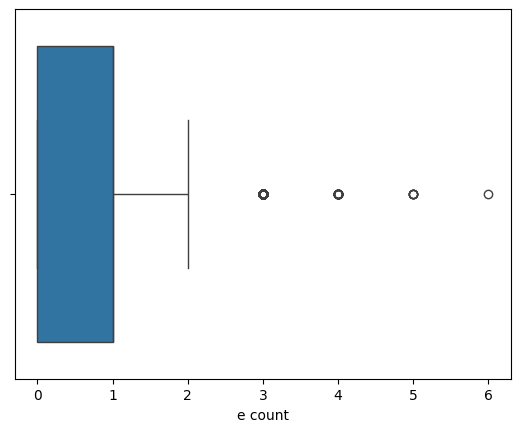

In [20]:
sns.boxplot(x = my_raw_data['e count'])
my_raw_data['e count'].value_counts()

In [21]:
outliers_e_count = outlier_list_maker('e count')
print(len(outliers_e_count))
# outliers_e_count

198


1    2175
0    1684
2     906
3     119
4       2
Name: a count, dtype: int64

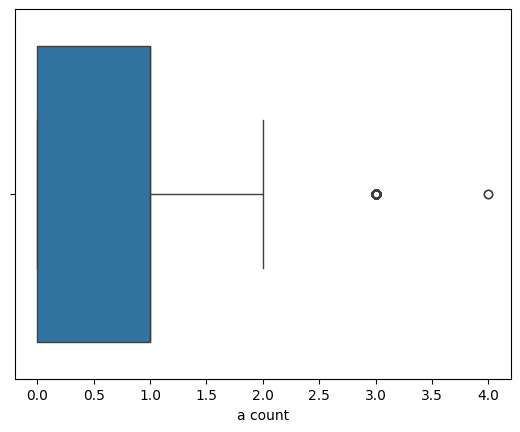

In [22]:
sns.boxplot(x = my_raw_data['a count'])
my_raw_data['a count'].value_counts()

0    2308
1    2077
2     460
3      40
4       1
Name: o count, dtype: int64

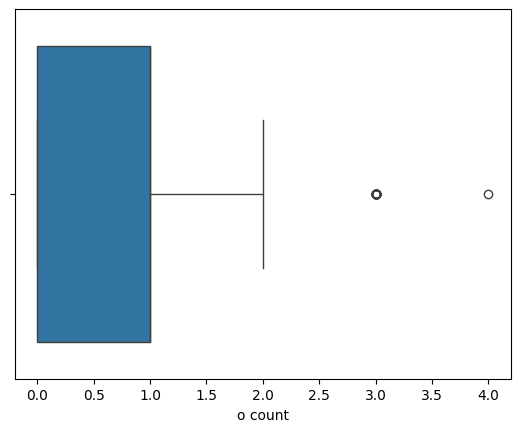

In [23]:
sns.boxplot(x = my_raw_data['o count'])
my_raw_data['o count'].value_counts()

0    3431
1    1330
2     122
3       3
Name: s count, dtype: int64

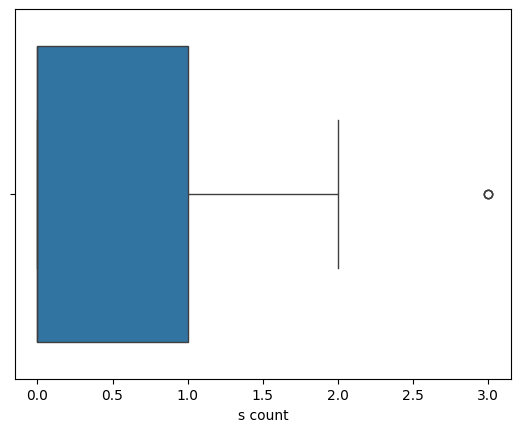

In [24]:
sns.boxplot(x = my_raw_data['s count'])
my_raw_data['s count'].value_counts()

array([[<Axes: xlabel='frequency score', ylabel='frequency score'>,
        <Axes: xlabel='Word length', ylabel='frequency score'>,
        <Axes: xlabel='# of vowels', ylabel='frequency score'>,
        <Axes: xlabel='# of consonants', ylabel='frequency score'>],
       [<Axes: xlabel='frequency score', ylabel='Word length'>,
        <Axes: xlabel='Word length', ylabel='Word length'>,
        <Axes: xlabel='# of vowels', ylabel='Word length'>,
        <Axes: xlabel='# of consonants', ylabel='Word length'>],
       [<Axes: xlabel='frequency score', ylabel='# of vowels'>,
        <Axes: xlabel='Word length', ylabel='# of vowels'>,
        <Axes: xlabel='# of vowels', ylabel='# of vowels'>,
        <Axes: xlabel='# of consonants', ylabel='# of vowels'>],
       [<Axes: xlabel='frequency score', ylabel='# of consonants'>,
        <Axes: xlabel='Word length', ylabel='# of consonants'>,
        <Axes: xlabel='# of vowels', ylabel='# of consonants'>,
        <Axes: xlabel='# of consonants', 

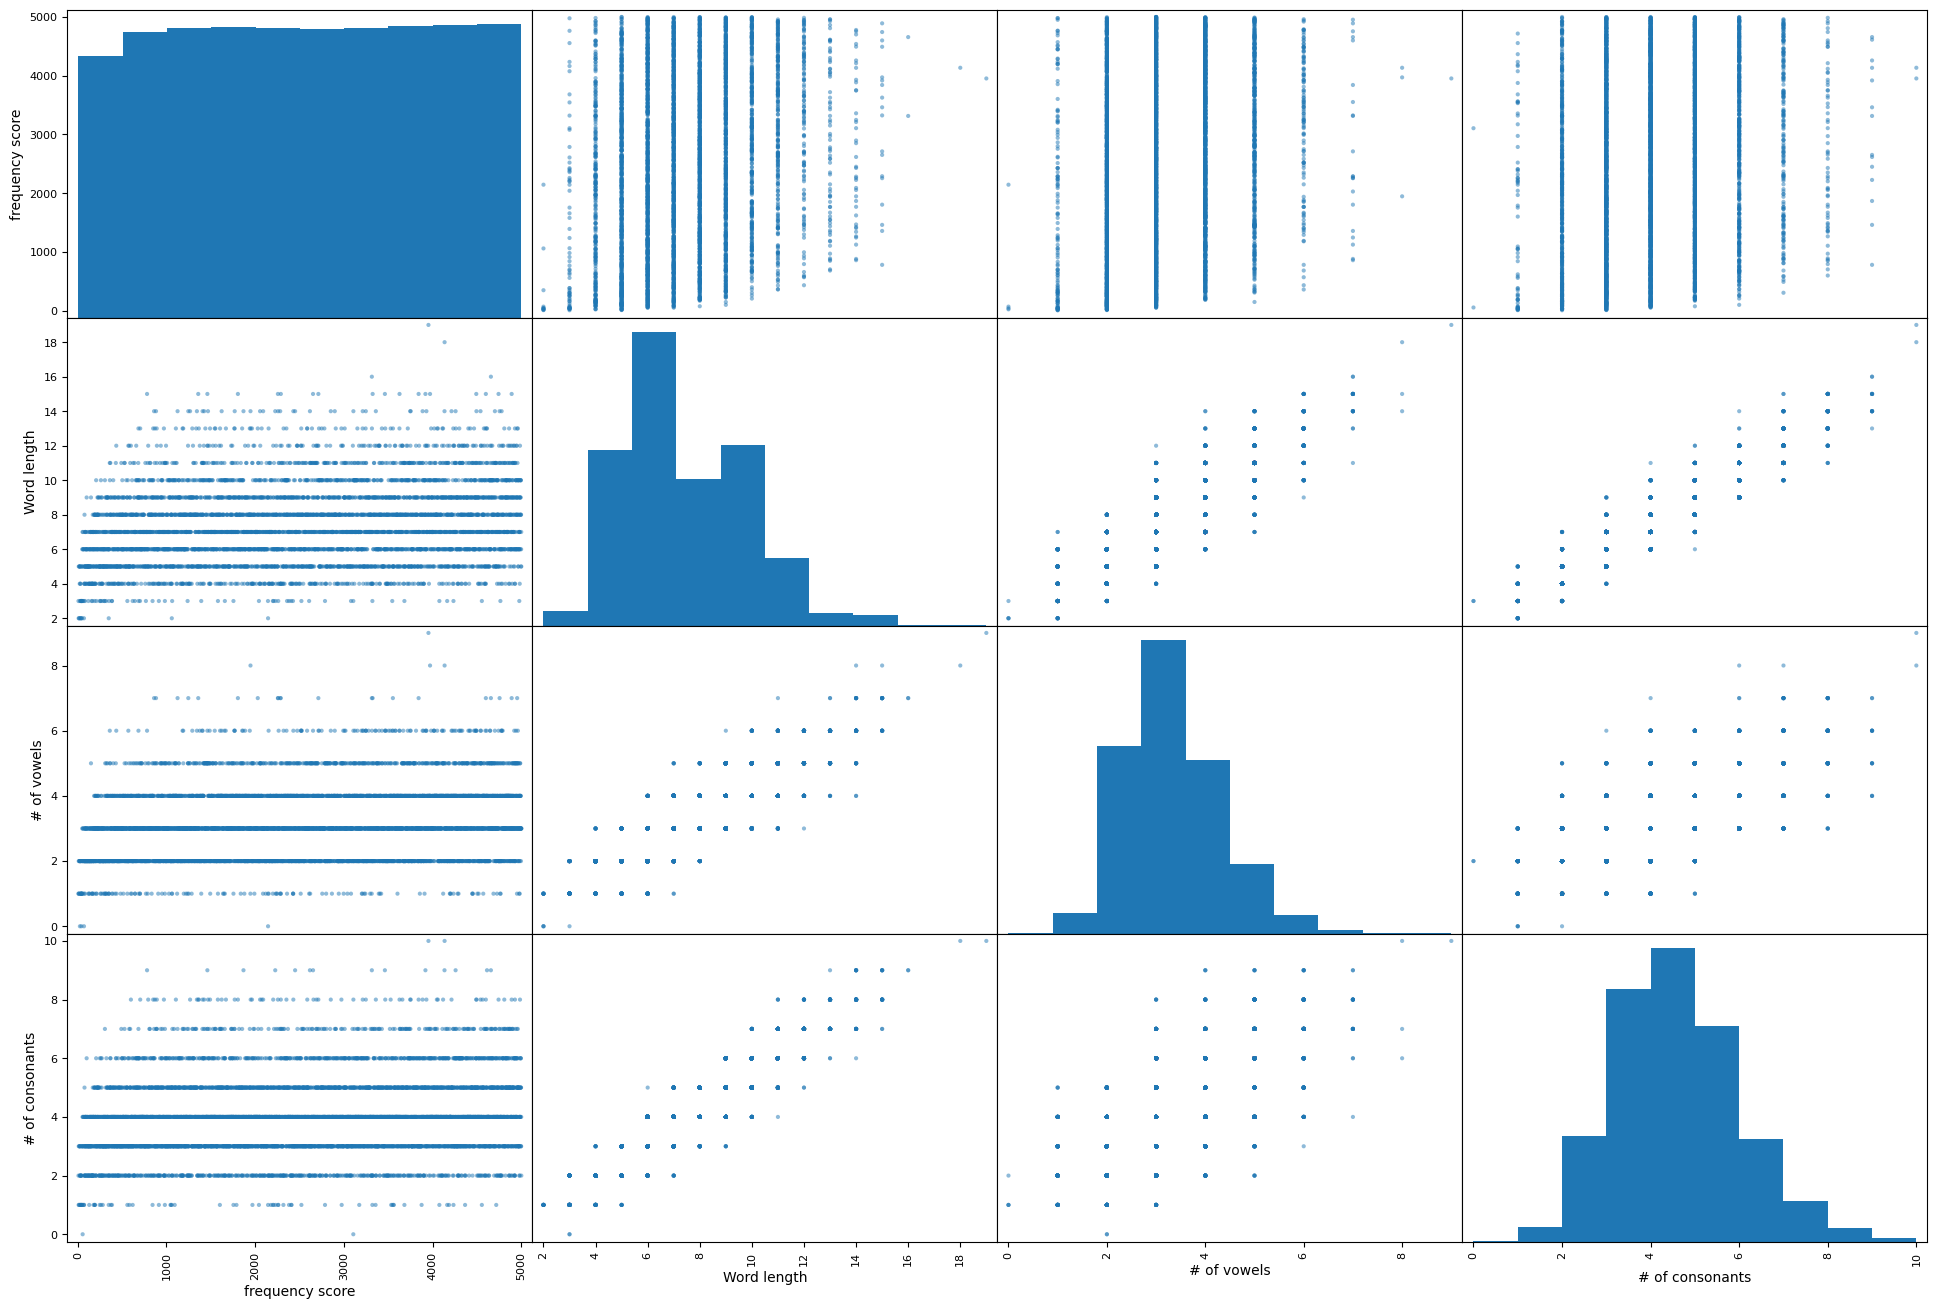

In [25]:
attributes = ['frequency score', 'Word length', '# of vowels', '# of consonants']

scatter_matrix(my_raw_data[attributes], figsize = (24, 16))

#Task 3: Data Preparation#


---
**Actions taken:**

**1. Deleted 'word length**' --> Redundant with '# of consonants' and '# of vowels'

**2. Deleted all parts of speech other than nouns, verbs, adjectives, adverbs** --> These represent the core word categories of a language (dare I say, adverbs could get cut too). The data set lost about 50 nouns (nm, nf), but this is neglibile when there are 2,449 nouns remaining

**3. Created 'consonants/word length' and 'vowels/word length'** --> These new variables could be valuable for predicting part of speech

**4. OneHotEncoded 'part of speech'** --> I orginally used ordinal labeling, but shifted to one hot encoding because there is no natural order to parts of speech

**5. Standardized all numerical value columns** --> Due to the presence of outliers in many columns, I used standardization instead of min-max scaling.



In [26]:
my_raw_data.head()

,Raw word,Part of Speech,frequency score,Word length,Contains special characters?,# of vowels,# of consonants,Contains repeated sequential characters?,Ends with a vowel?,e count,a count,o count,s count
0,abajo,adv,631,5,False,3,2,False,True,0,2,1,0
1,abandonado,adj,2298,10,False,5,5,False,True,0,3,2,0
2,abandonar,v,638,9,False,4,5,False,False,0,3,1,0
3,abandono,noun,2524,8,False,4,4,False,True,0,2,2,0
4,abanico,noun,4422,7,False,4,3,False,True,0,2,1,0


In [27]:
my_raw_data['Part of Speech'].value_counts()

noun    2449
adj     1091
v       1074
adv      203
nm        26
nf        25
pron      10
num        8
Name: Part of Speech, dtype: int64

In [28]:
# creating copy

cleaner_data = my_raw_data.copy()

In [29]:
values_to_remove = ['nm', 'nf', 'pron', 'num']
cleaner_data = cleaner_data.drop(my_raw_data[my_raw_data['Part of Speech'].isin(values_to_remove)].index)

In [30]:
cleaner_data['Part of Speech'].value_counts()

noun    2449
adj     1091
v       1074
adv      203
Name: Part of Speech, dtype: int64

In [31]:
cleaner_data['consonants/word length'] = cleaner_data['# of consonants'] / cleaner_data['Word length']
# I will not keep consonants/word length because it's correlation with frequency score is -0.02, which is far less than the 0.18 correlation
# of consonant count by itself. Lets see if the same thing happens with vowels....

cleaner_data['vowels/word length'] = cleaner_data['# of vowels']/cleaner_data['Word length']
# Will not keep 'vowels/word length' for the same reason as consonants/word length.

# Correction: I will keep both new variables created in this code block because they both have higher correlations with part of speech.

In [32]:
check_1 = change_checker(cleaner_data)
check_1

'3684dbef6722f41c4955264fe79b884347ed5f73b1b3b24da082163bb4246866'

In [33]:
cleaner_data = cleaner_data.drop(columns=['Word length'])

In [34]:
check_2 = change_checker(cleaner_data)
check_2

'dffd7add2432f3e9c048d32db19cb32b5b872d1c016de04a53d4e6aa86f709aa'

In [35]:
# cat_encoder = OneHotEncoder()
# part_of_speech_1hot = cat_encoder.fit_transform(cleaner_data[['Part of Speech']])

speech_cols = pd.get_dummies(cleaner_data['Part of Speech'])

cleaner_data = cleaner_data.drop(columns = 'Part of Speech')

cleaner_data = cleaner_data.join(speech_cols.drop(columns = 'adv'))

In [36]:
cleaner_data.head()

,Raw word,frequency score,Contains special characters?,# of vowels,# of consonants,Contains repeated sequential characters?,Ends with a vowel?,e count,a count,o count,s count,consonants/word length,vowels/word length,adj,noun,v
0,abajo,631,False,3,2,False,True,0,2,1,0,0.400000,0.600000,0,0,0
1,abandonado,2298,False,5,5,False,True,0,3,2,0,0.500000,0.500000,1,0,0
2,abandonar,638,False,4,5,False,False,0,3,1,0,0.555556,0.444444,0,0,1
3,abandono,2524,False,4,4,False,True,0,2,2,0,0.500000,0.500000,0,1,0
4,abanico,4422,False,4,3,False,True,0,2,1,0,0.428571,0.571429,0,1,0


array([[<Axes: title={'center': 'frequency score'}>,
        <Axes: title={'center': '# of vowels'}>,
        <Axes: title={'center': '# of consonants'}>],
       [<Axes: title={'center': 'e count'}>,
        <Axes: title={'center': 'a count'}>,
        <Axes: title={'center': 'o count'}>],
       [<Axes: title={'center': 's count'}>,
        <Axes: title={'center': 'consonants/word length'}>,
        <Axes: title={'center': 'vowels/word length'}>],
       [<Axes: title={'center': 'adj'}>,
        <Axes: title={'center': 'noun'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

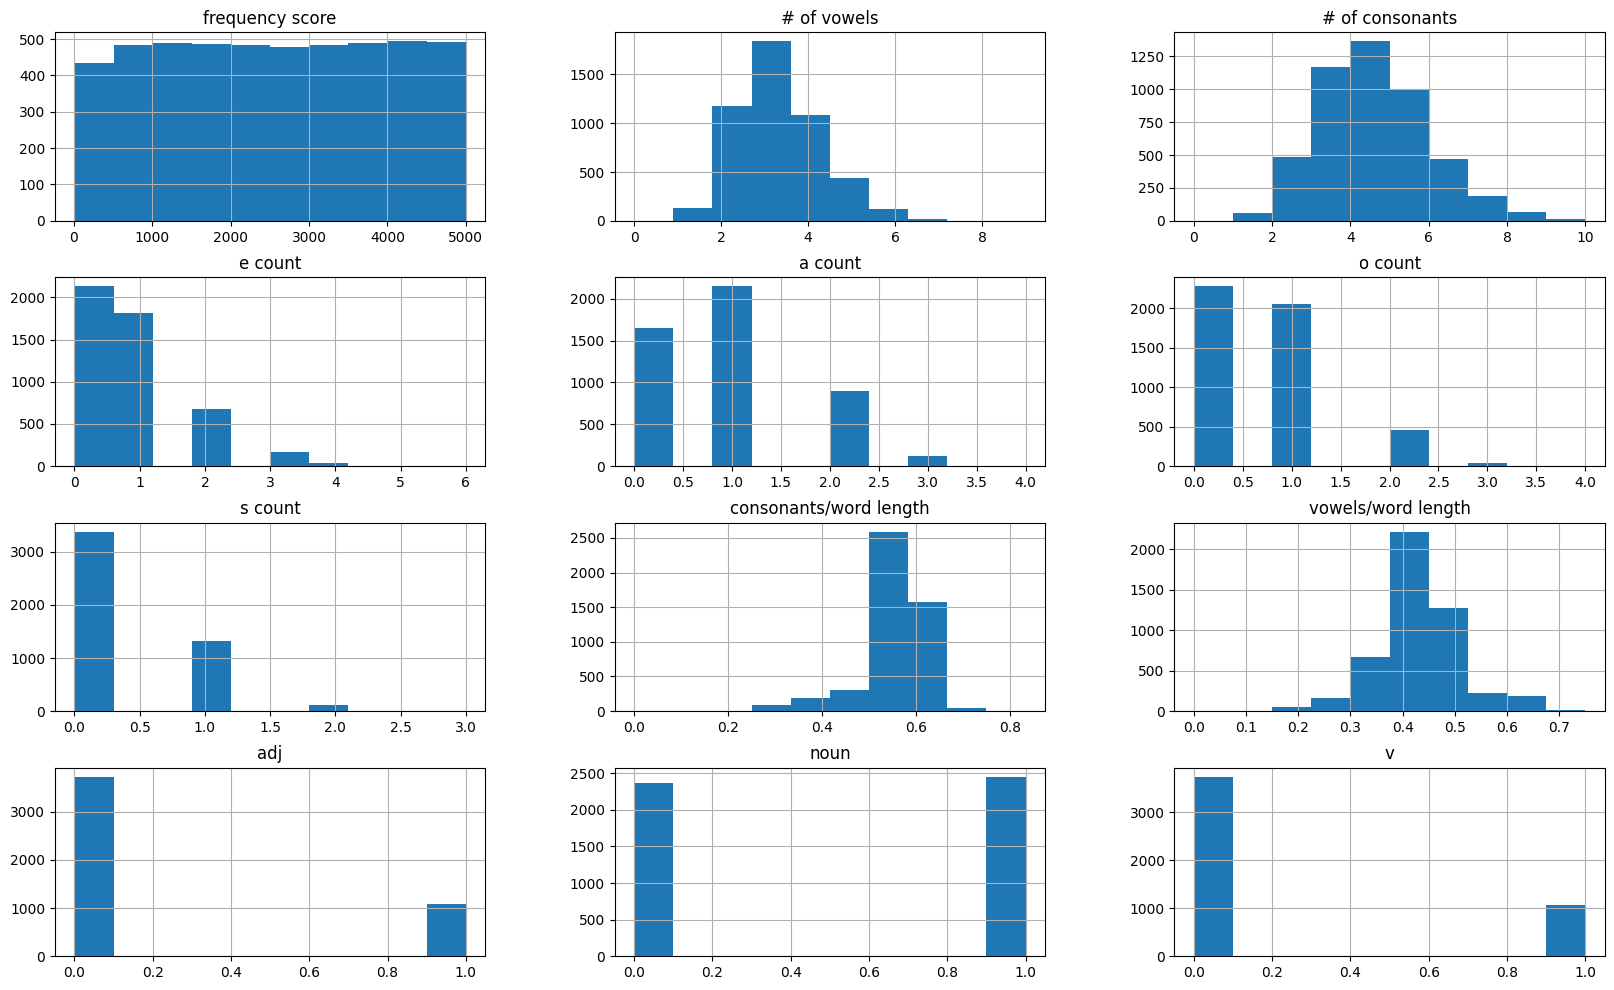

In [37]:
cleaner_data.hist(figsize=(20,12))

In [38]:
scaler = StandardScaler()
num_cols = ['# of vowels', '# of consonants', 'o count', 'e count', 'a count', 's count', 'consonants/word length', 'vowels/word length']

scaler.fit(cleaner_data[num_cols])

cleaner_data[num_cols] = scaler.transform(cleaner_data[num_cols])

len(num_cols)

8

array([[<Axes: title={'center': 'frequency score'}>,
        <Axes: title={'center': '# of vowels'}>,
        <Axes: title={'center': '# of consonants'}>],
       [<Axes: title={'center': 'e count'}>,
        <Axes: title={'center': 'a count'}>,
        <Axes: title={'center': 'o count'}>],
       [<Axes: title={'center': 's count'}>,
        <Axes: title={'center': 'consonants/word length'}>,
        <Axes: title={'center': 'vowels/word length'}>],
       [<Axes: title={'center': 'adj'}>,
        <Axes: title={'center': 'noun'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

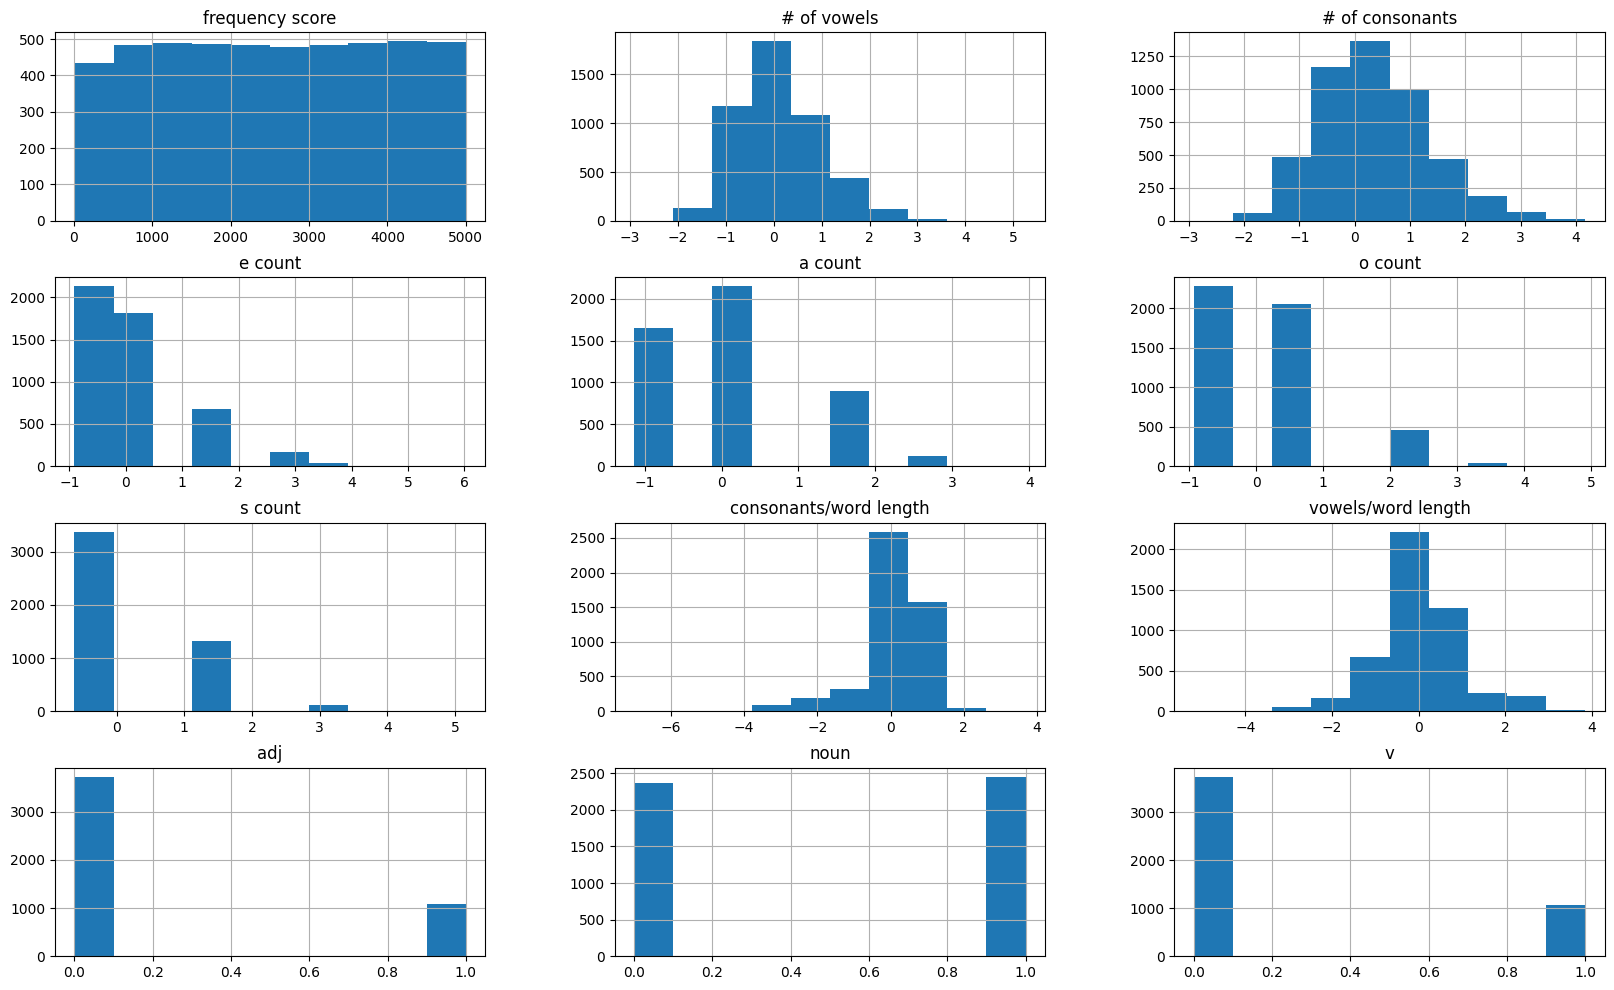

In [39]:
cleaner_data.hist(figsize=(20,12))

In [40]:
cleaner_data.corr()

<ipython-input-40-9368ae9aa57b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cleaner_data.corr()


,frequency score,Contains special characters?,# of vowels,# of consonants,Contains repeated sequential characters?,Ends with a vowel?,e count,a count,o count,s count,consonants/word length,vowels/word length,adj,noun,v
frequency score,1.000000,0.061288,0.198354,0.180163,0.042712,0.072126,0.046387,0.093336,0.034426,0.041791,-0.023277,0.009414,0.057414,0.060474,-0.101808
Contains special characters?,0.061288,1.000000,-0.127397,0.025113,0.008085,-0.093476,-0.131274,-0.127991,-0.035821,0.014376,-0.215038,-0.423544,-0.012094,0.189603,-0.223461
# of vowels,0.198354,-0.127397,1.000000,0.631973,-0.014375,0.146333,0.422646,0.221105,0.161223,0.120913,-0.278119,0.422455,0.115892,-0.084061,-0.095271
# of consonants,0.180163,0.025113,0.631973,1.000000,0.092509,-0.179967,0.386681,0.100139,0.024265,0.220701,0.466975,-0.360507,0.020228,-0.186850,0.123613
Contains repeated sequential characters?,0.042712,0.008085,-0.014375,0.092509,1.000000,-0.018324,0.001012,0.023049,-0.016649,-0.063295,0.114693,-0.100567,-0.052028,0.050301,0.002771
Ends with a vowel?,0.072126,-0.093476,0.146333,-0.179967,-0.018324,1.000000,0.098834,-0.100172,0.316389,0.012924,-0.355116,0.378781,0.262179,0.261791,-0.632477
e count,0.046387,-0.131274,0.422646,0.386681,0.001012,0.098834,1.000000,-0.199985,-0.192127,0.073173,0.028632,0.082497,-0.002596,-0.105315,-0.005843
a count,0.093336,-0.127991,0.221105,0.100139,0.023049,-0.100172,-0.199985,1.000000,-0.320779,-0.081791,-0.065487,0.152584,-0.160451,-0.004843,0.150860
o count,0.034426,-0.035821,0.161223,0.024265,-0.016649,0.316389,-0.192127,-0.320779,1.000000,0.047567,-0.129909,0.155481,0.293508,-0.021742,-0.222700
s count,0.041791,0.014376,0.120913,0.220701,-0.063295,0.012924,0.073173,-0.081791,0.047567,1.000000,0.102798,-0.085411,0.080898,-0.050514,-0.018203


In [41]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
# file_path = '/content/gdrive/MyDrive/Spring 24/Python for ML/HW 1/cleaned_spanish_data.csv'
# cleaner_data.to_csv(file_path, index=False)